In [2]:
jet.GetEntry(100)

749

In [5]:
import ROOT as rt
import numpy as np
import math
import mxnet as mx
import datetime
start=datetime.datetime.now()
record=mx.recordio.MXRecordIO('tmp.rec','w')
jetset=[]
labels=[]
maxx=0.05
maxy=0.05
arnum=16
bx=2*maxx/(2*arnum+1)
by=2*maxy/(2*arnum+1)
read=rt.TFile('jet2.root')
jet=rt.gDirectory.Get('jetAnalyser/jetAnalyser')
entries=jet.GetEntriesFast()
overlap=np.zeros(shape=(3,2*arnum+1,2*arnum+1))
gover=np.zeros(shape=(3,2*arnum+1,2*arnum+1))
qover=np.zeros(shape=(3,2*arnum+1,2*arnum+1))
for ent in range(entries):
    if ent>1000000:
        break
    jet.GetEntry(ent)
    #if jet.pt<300 or jet.pt>400:
        #continue
    if jet.partonId==0:
        continue
    palet=np.zeros(shape=(3,2*arnum+1,2*arnum+1))
    r=0
    g=0
    b=0
    for i in range(len(jet.dau_pt)):
        x=int(math.floor((jet.dau_deta[i]/bx)+0.5)+arnum)
        if x<0 or x>2*arnum:
            continue
        y=int(math.floor((jet.dau_dphi[i]/by)+0.5)+arnum)
        if y<0 or y>2*arnum:
            continue
        pt=jet.dau_pt[i]
        if jet.dau_charge[i]==0:
            palet[1][x][y]+=pt
            #overlap[1][x][y]+=pt
            if palet[1][x][y]>g:
                g=palet[1][x][y]
        else:
            palet[0][x][y]+=pt
            palet[2][x][y]+=1
            #overlap[0][x][y]+=pt
            #overlap[2][x][y]+=1
            if palet[0][x][y]>r:
                r=palet[0][x][y]
            if palet[2][x][y]>b:
                b=palet[2][x][y]
            #pass
    #record.write(palet)
    for i in range(2*arnum+1):
        for j in range(2*arnum+1):
            if r!=0:
                palet[0][i][j]=255*palet[0][i][j]/r
            if g!=0:
                palet[1][i][j]=255*palet[1][i][j]/g
            if b!=0:
                palet[2][i][j]=255*palet[2][i][j]/b
    
    jetset.append(palet)
    if jet.partonId==21:
        labels.append(1)
        gover=np.add(gover,palet)
    else:
        labels.append(0)
        qover=np.add(qover,palet)
    overlap=np.add(overlap,palet)
    

[r,g,b]=[0,0,0]
[gr,gg,gb]=[0,0,0]
[qr,qg,qb]=[0,0,0]
for i in range(2*arnum+1):
        for j in range(2*arnum+1):
            if overlap[0][i][j]>r:
                r=overlap[0][i][j]
            if overlap[1][i][j]>g:
                g=overlap[1][i][j]
            if overlap[2][i][j]>b:
                b=overlap[2][i][j]
            """
            if gover[0][i][j]>gr:
                gr=gover[0][i][j]
            if gover[1][i][j]>gg:
                gg=gover[1][i][j]
            if gover[2][i][j]>gb:
                gb=gover[2][i][j]
            if qover[0][i][j]>qr:
                qr=qover[0][i][j]
            if qover[1][i][j]>qg:
                qg=qover[1][i][j]
            if qover[2][i][j]>qb:
                qb=qover[2][i][j]
            """
                
for i in range(2*arnum+1):
        for j in range(2*arnum+1):
            if r!=0:
                overlap[0][i][j]=overlap[0][i][j]/r
            if g!=0:
                overlap[1][i][j]=overlap[1][i][j]/g
            if b!=0:
                overlap[2][i][j]=overlap[2][i][j]/b
            """
            if gr!=0:
                gover[0][i][j]=gover[0][i][j]/gr
            if gg!=0:
                gover[1][i][j]=gover[1][i][j]/gg
            if gb!=0:
                gover[2][i][j]=gover[2][i][j]/gb
            if qr!=0:
                qover[0][i][j]=qover[0][i][j]/qr
            if qg!=0:
                qover[1][i][j]=qover[1][i][j]/qg
            if qb!=0:
                qover[2][i][j]=qover[2][i][j]/qb
            """
labels=np.array(labels)
jetset=np.array(jetset)
print jetset.shape
record.close()
print datetime.datetime.now()-start

(14948, 3, 33, 33)
0:00:42.647796


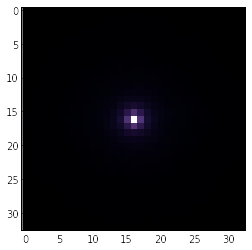

[0 0 1 ..., 1 0 0]


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
bkb=np.swapaxes(overlap,0,1)
bkb=np.swapaxes(bkb,1,2)
plt.imshow(bkb,interpolation='none')
print labels
plt.show()

In [8]:
import mxnet as mx
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve, average_precision_score
batch_size=100
data_train, data_test, label_train, label_test = train_test_split(255*jetset.reshape(len(jetset),3*33*33), labels, test_size=0.3,
                                                                    random_state=random.randrange(0,10000))
#data_train=data1[:int(len(data1)*0.7)]
#data_test=data1[int(len(data1)*0.7):]
#label_train=labels[:int(len(labels)*0.7)]
#label_test=labels[int(len(labels)*0.7):]
data_train=data_train.reshape(len(data_train),3,33,33)
data_test=data_test.reshape(len(data_test),3,33,33)
print data_train.shape
train_iter = mx.io.NDArrayIter(data_train, label_train, batch_size, shuffle=False)
val_iter = mx.io.NDArrayIter(data_test, label_test, batch_size)

data = mx.sym.var('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="relu")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="relu")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="relu")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=2)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
#mx.viz.plot_network(lenet)

(10463, 3, 33, 33)


In [9]:
import mxnet as mx
data=mx.sym.var('data')
conv1 = mx.sym.Convolution(data=data, kernel=(3,3),pad=(1,1), num_filter=64)
relu1 = mx.sym.Activation(data=conv1, act_type="relu")
pool1 = mx.sym.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2))
conv2 = mx.sym.Convolution(data=pool1, kernel=(3,3),pad=(1,1), num_filter=128)
relu2 = mx.sym.Activation(data=conv2, act_type="relu")
pool2 = mx.sym.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2))
conv3 = mx.sym.Convolution(data=pool2, kernel=(3,3),pad=(1,1), num_filter=256)
relu3 = mx.sym.Activation(data=conv3, act_type="relu")
conv4 = mx.sym.Convolution(data=relu3, kernel=(3,3),pad=(1,1), num_filter=256)
relu4 = mx.sym.Activation(data=conv4, act_type="relu")
pool3 = mx.sym.Pooling(data=relu4, pool_type="max", kernel=(2,2), stride=(2,2))
flatten = mx.sym.flatten(data=pool3)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=4096)
relu9 = mx.sym.Activation(data=fc1, act_type="relu")
drop1=mx.sym.Dropout(data=relu9)
fc2 = mx.symbol.FullyConnected(data=drop1, num_hidden=4096)
relu10 = mx.sym.Activation(data=fc2, act_type="relu")
drop2=mx.sym.Dropout(data=relu10)
fc3 = mx.symbol.FullyConnected(data=drop2, num_hidden=2)
vggnet=mx.sym.SoftmaxOutput(data=fc3, name='softmax')
#mx.viz.plot_network(vggnet,shape={"data":(1,3,33,33)})
print "vgg"

vgg


In [25]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=vggnet, context=mx.gpu())
# train with the same 
"""
batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
optimizer_params={'learning_rate':0.1},
"""
#optimizer_params={'learning_rate':0.5,'beta1':0.1,'beta2':0.111},
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.1},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=20)

INFO:root:Epoch[0] Train-accuracy=0.536286
INFO:root:Epoch[0] Time cost=1.780
INFO:root:Epoch[0] Validation-accuracy=0.540000
INFO:root:Epoch[1] Train-accuracy=0.579619
INFO:root:Epoch[1] Time cost=1.546
INFO:root:Epoch[1] Validation-accuracy=0.548667
INFO:root:Epoch[2] Train-accuracy=0.604571
INFO:root:Epoch[2] Time cost=1.548
INFO:root:Epoch[2] Validation-accuracy=0.540000
INFO:root:Epoch[3] Train-accuracy=0.597810
INFO:root:Epoch[3] Time cost=1.547
INFO:root:Epoch[3] Validation-accuracy=0.557333
INFO:root:Epoch[4] Train-accuracy=0.635714
INFO:root:Epoch[4] Time cost=1.549
INFO:root:Epoch[4] Validation-accuracy=0.573556
INFO:root:Epoch[5] Train-accuracy=0.642667
INFO:root:Epoch[5] Time cost=1.549
INFO:root:Epoch[5] Validation-accuracy=0.620667
INFO:root:Epoch[6] Train-accuracy=0.658286
INFO:root:Epoch[6] Time cost=1.547
INFO:root:Epoch[6] Validation-accuracy=0.663778
INFO:root:Epoch[7] Train-accuracy=0.664571
INFO:root:Epoch[7] Time cost=1.546
INFO:root:Epoch[7] Validation-accuracy=0

In [20]:
lenet_model.save_checkpoint(prefix='300pt',epoch=5)

INFO:root:Saved checkpoint to "300pt-0005.params"


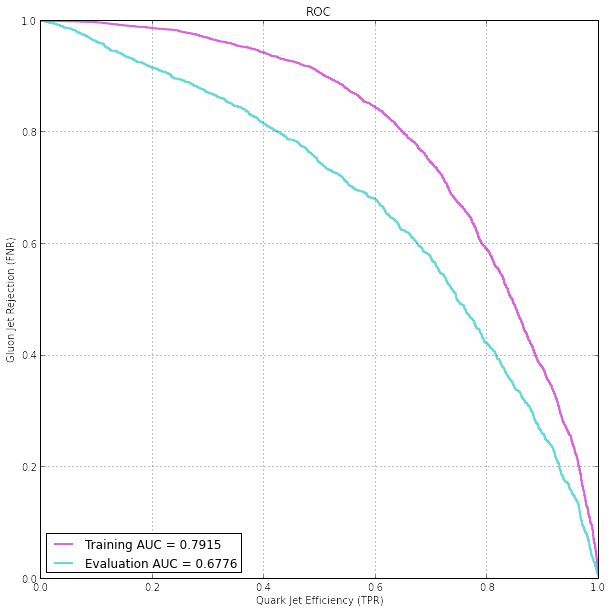

In [26]:
valpred=lenet_model.predict(val_iter).asnumpy()[:,1]

trainpred=lenet_model.predict(train_iter).asnumpy()[:,1]

t_fpr, t_tpr, _ = roc_curve( label_train, trainpred)
t_fnr = 1 - t_fpr
e_fpr, e_tpr, _ = roc_curve( label_test, valpred )
e_fnr = 1 - e_fpr

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure( figsize=(10, 10) )
train_auc = np.around( auc(t_fpr, t_tpr), 4 )
eval_auc = np.around( auc(e_fpr, e_tpr), 4 )
plt.title( "ROC" )
plt.xlabel( "Quark Jet Efficiency (TPR)" )
plt.ylabel( "Gluon Jet Rejection (FNR)" )
plt.plot( t_tpr, t_fnr, alpha=0.6, c='m', label="Training AUC = {}".format( train_auc ), lw=2 )
plt.plot( e_tpr, e_fnr, alpha=0.6, c='c', label="Evaluation AUC = {}".format( eval_auc ), lw=2 )
plt.plot( [0,1], [1, 1], c='k', alpha=1, linestyle='dashed' )
plt.plot( [1,1], [0, 1], c='k', alpha=1, linestyle='dashed' )
plt.legend( loc='lower left' )
plt.xlim((0, 1.))
plt.ylim((0, 1.))
plt.grid()
plt.show()

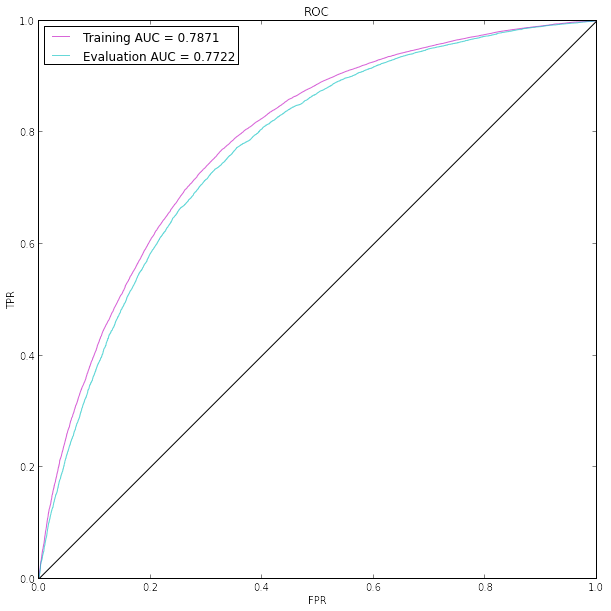

In [21]:
valpred=lenet_model.predict(val_iter).asnumpy()[:,1]

trainpred=lenet_model.predict(train_iter).asnumpy()[:,1]

t_fpr, t_tpr, _ = roc_curve( label_train, trainpred)
t_fnr = 1 - t_fpr

e_fpr, e_tpr, _ = roc_curve( label_test, valpred )

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure( figsize=(10, 10) )
train_auc = np.around( auc(t_fpr, t_tpr), 4 )
eval_auc = np.around( auc(e_fpr, e_tpr), 4 )
plt.title( "ROC" )
plt.xlabel( "FPR" )
plt.ylabel( "TPR" )
plt.plot( t_fpr, t_tpr, alpha=0.6, c='m', label="Training AUC = {}".format( train_auc ) )
plt.plot( e_fpr, e_tpr, alpha=0.6, c='c', label="Evaluation AUC = {}".format( eval_auc ) )
plt.plot( [0,1], [0, 1], c='k', alpha=1 )
plt.legend( loc=2 )
plt.show()

In [36]:
plt.plot?